## rPPG Transformer Model (Physiological + Temporal Attention)

In this section, we implement a Transformer-based rPPG deepfake detector.

**Goal:**  
Capture long-range temporal dependencies in physiological signals using a Transformer encoder to classify **real vs fake**.

### Pipeline

1. **Preprocessing**
   - Read video frames with OpenCV.
   - Detect face using MTCNN (fall back to center crop if detection fails).
   - From the face bounding box, crop a stable skin region (cheeks/forehead).
   - Sample a fixed-length clip, e.g., `T = 128` frames.
   - Resize crops to a fixed size, e.g., `H = W = 112`.

2. **rPPG Spatial-Temporal Stem (3D CNN)**
   - Extract low-level spatial-temporal features using a series of 3D Convolutional blocks.
   - Apply **Spatial Attention** to focus on skin regions relevant to the pulse signal.
   - Global Average Pooling over spatial dimensions to obtain a time-series of feature vectors `[B, T, D]`.

3. **Temporal Transformer Encoder**
   - Add **Positional Encodings** to retain sequence order information.
   - Append a learnable **CLS token** (similar to ViT/BERT) for classification.
   - Pass through multiple **Transformer Encoder Layers** (Self-Attention) to model global temporal context.

4. **Classification**
   - Extract the `CLS` token output.
   - Pass through a linear layer to predict the binary label (real / fake).

5. **Training**
   - Binary classification with `BCEWithLogitsLoss`.
   - Optimized using `AdamW` and `CosineAnnealingLR` scheduler.

### Imports, config, and seeding

In [1]:
import os
import random
import math
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


from sklearn.metrics import roc_auc_score

# Optional: facenet-pytorch for MTCNN face detection
try:
    from facenet_pytorch import MTCNN
    FACENET_AVAILABLE = True
except ImportError:
    FACENET_AVAILABLE = False
    print("facenet-pytorch not installed. We'll fall back to simple center crop.")

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_ROOT = Path("/kaggle/input/celeb-df-v2")
METADATA_CSV = Path("metadata_celebdf_v2.csv")
CHECKPOINT_DIR = "checkpoints"

# rPPG / clip config
CLIP_LEN = 64        # number of frames per clip
FRAME_SIZE = 96      # crop size
FPS_TARGET = 25       # for sampling; we will sample uniformly by frame index

# Training config
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 1e-4
NUM_EPOCHS = 15


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

set_seed(42)

print("Device:", DEVICE)

facenet-pytorch not installed. We'll fall back to simple center crop.
Device: cuda


## Celeb-DF (v2) Metadata Builder + Official Test Split

Celeb-DF (v2) is organized into three main folders:

- `Celeb-real` – real face videos (originals)
- `YouTube-real` – additional real videos
- `Celeb-synthesis` – DeepFake synthesized videos

There is also a text file:
- `List_of_testing_videos.txt` – list of videos assigned to the official **test set** in the original paper.

In this feature we:

1. Scan these folders to build a `metadata_celebdf_v2.csv` file with:
   - `video_path`: path to each video **relative to the dataset root**
   - `label`: `0` for real, `1` for fake
   - `split`: `train` or `test` (based on the official test list)

2. Update our `CelebDFRPPGDataset` to:
   - Respect the `split` column when creating `train`, `val`, and `test` sets
   - Use only non-test videos for `train` and `val`, splitting them with a configurable `val_ratio`

### Build metadata_celebdf_v2.csv from folder structure + test list

In [2]:
from pathlib import Path
import os
import pandas as pd

DATA_ROOT = Path("/kaggle/input/celeb-df-v2")

test_list_path = DATA_ROOT / "List_of_testing_videos.txt"
if not test_list_path.exists():
    raise FileNotFoundError(f"Cannot find List_of_testing_videos.txt at {test_list_path}")

test_paths = []

with open(test_list_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()

        # Format: "<label_flag> <relative_path>"
        # label_flag: "0" = real, "1" = fake
        if len(parts) >= 2 and parts[0] in {"0", "1"}:
            # label_flag = int(parts[0])  # we could use this, but folder already encodes it
            rel_path = parts[1]
        else:
            # Fallback: last token is path
            rel_path = parts[-1]

        test_paths.append(rel_path)

test_set = set(test_paths)
print(f"Loaded {len(test_set)} test entries (all lines) from {test_list_path.name}")

rows = []

label_map = {
    "Celeb-real": 0,        # real
    "YouTube-real": 0,      # real
    "Celeb-synthesis": 1    # fake
}

video_dirs = ["Celeb-real", "YouTube-real", "Celeb-synthesis"]

for vd in video_dirs:
    folder = DATA_ROOT / vd
    if not folder.exists():
        print(f"[WARN] Folder not found: {folder}")
        continue

    video_files = []
    for ext in ("*.mp4", "*.avi", "*.mov", "*.mkv"):
        video_files.extend(folder.rglob(ext))

    print(f"Scanning {folder.name}: found {len(video_files)} video files.")

    for vf in video_files:
        # Path relative to DATA_ROOT, to match the txt file entries
        rel_path = vf.relative_to(DATA_ROOT).as_posix()
        label = label_map.get(vf.parent.name, None)
        if label is None:
            continue

        split = "test" if rel_path in test_set else "train"

        rows.append({
            "video_path": rel_path,
            "label": label,   
            "split": split
        })

metadata_df = pd.DataFrame(rows)
print("Total videos collected:", len(metadata_df))

METADATA_CSV = Path("metadata_celebdf_v2.csv")
metadata_df.to_csv(METADATA_CSV, index=False)

print(f"Saved metadata to {METADATA_CSV.resolve()}")
display(metadata_df.head())
print(metadata_df["split"].value_counts())
print(metadata_df.groupby(["split", "label"]).size())

Loaded 518 test entries (all lines) from List_of_testing_videos.txt
Scanning Celeb-real: found 590 video files.
Scanning YouTube-real: found 300 video files.
Scanning Celeb-synthesis: found 5639 video files.
Total videos collected: 6529
Saved metadata to /kaggle/working/metadata_celebdf_v2.csv


,video_path,label,split
0,Celeb-real/id49_0006.mp4,0,train
1,Celeb-real/id27_0008.mp4,0,test
2,Celeb-real/id32_0000.mp4,0,train
3,Celeb-real/id1_0006.mp4,0,test
4,Celeb-real/id50_0006.mp4,0,test


split
train    6011
test      518
Name: count, dtype: int64
split  label
test   0         178
       1         340
train  0         712
       1        5299
dtype: int64


### CelebDFRPPGDataset using metadata split (train/val/test)

In [3]:
# Consolidated Utilities: Video Reading, Face Detection, Preprocessing
import cv2
import numpy as np
import torch
import math
import random
import signal
import multiprocessing as mp
import time
import signal
import multiprocessing as mp

# Hard cap to prevent hangs on broken files
READ_VIDEO_TIMEOUT = 10


class VideoReadTimeout(Exception):
    """Exception raised when video reading times out."""
    pass


def _timeout_handler(signum, frame):
    """Signal handler for timeout."""
    raise VideoReadTimeout("Video read timed out")


def _read_video_worker(path, max_frames, result_queue):
    """Worker function for multiprocessing-based video reading."""
    frames = []
    try:
        cap = cv2.VideoCapture(str(path))
        if not cap.isOpened():
            result_queue.put(("error", "open_fail"))
            return

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
        max_frames_local = min(max_frames, frame_count) if frame_count > 0 else max_frames

        count = 0
        consecutive_failures = 0

        while count < max_frames_local:
            ret, frame = cap.read()
            if not ret:
                consecutive_failures += 1
                if consecutive_failures >= 3:
                    break
                continue
            consecutive_failures = 0
            frames.append(frame)
            count += 1

        cap.release()
        result_queue.put(("success", frames))
    except Exception as e:
        result_queue.put(("error", str(e)))


def read_video_frames(path: str, max_frames: int = None, timeout: float = READ_VIDEO_TIMEOUT):
    """
    Read frames from a video using OpenCV with a hard timeout.
    Uses signal-based timeout on Linux (Kaggle) or multiprocessing fallback.
    Returns [] if slow or failing.
    """
    if max_frames is None:
        max_frames = CLIP_LEN * 2

    # Try signal-based timeout first (works on Linux/Kaggle in main thread)
    try:
        # Check if we're in the main thread (signal only works there)
        import threading
        if threading.current_thread() is threading.main_thread():
            return _read_video_with_signal_timeout(path, max_frames, timeout)
    except:
        pass

    # Fallback: use multiprocessing with timeout
    return _read_video_with_mp_timeout(path, max_frames, timeout)


def _read_video_with_signal_timeout(path, max_frames, timeout):
    """Read video with signal-based timeout (Linux only, main thread only)."""
    frames = []
    cap = None

    # Set up timeout signal
    old_handler = signal.signal(signal.SIGALRM, _timeout_handler)
    signal.alarm(int(timeout))

    try:
        cap = cv2.VideoCapture(str(path))
        if not cap.isOpened():
            print(f"[WARN] Cannot open video: {path}")
            return []

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
        max_frames_local = min(max_frames, frame_count) if frame_count > 0 else max_frames

        count = 0
        consecutive_failures = 0

        while count < max_frames_local:
            ret, frame = cap.read()
            if not ret:
                consecutive_failures += 1
                if consecutive_failures >= 3:
                    break
                continue
            consecutive_failures = 0
            frames.append(frame)
            count += 1

    except VideoReadTimeout:
        print(f"[WARN] Timeout reading video (>{timeout}s): {path}")
        frames = []
    except Exception as e:
        print(f"[WARN] Exception reading {path}: {e}")
        frames = []
    finally:
        signal.alarm(0)  # Cancel the alarm
        signal.signal(signal.SIGALRM, old_handler)  # Restore old handler
        if cap is not None:
            try:
                cap.release()
            except:
                pass

    return frames


def _read_video_with_mp_timeout(path, max_frames, timeout):
    """Read video using multiprocessing with timeout (works in worker processes)."""
    ctx = mp.get_context('spawn')
    result_queue = ctx.Queue()

    proc = ctx.Process(target=_read_video_worker, args=(path, max_frames, result_queue))
    proc.start()
    proc.join(timeout)

    if proc.is_alive():
        print(f"[WARN] Timeout reading video (>{timeout}s): {path}")
        proc.terminate()
        proc.join(1)
        if proc.is_alive():
            proc.kill()
        return []

    try:
        if not result_queue.empty():
            status, data = result_queue.get_nowait()
            if status == "success":
                return data
            else:
                print(f"[WARN] Error reading {path}: {data}")
                return []
    except:
        pass

    return []


def sample_frame_indices(num_frames: int, clip_len: int, random_start: bool = True):
    """
    Sample `clip_len` indices from a video of length `num_frames`.
    If video is shorter than clip_len, we loop / pad by repeating frames.
    """
    if num_frames <= 0:
        return []

    if num_frames >= clip_len:
        if random_start:
            start = random.randint(0, max(0, num_frames - clip_len))
        else:
            start = max(0, (num_frames - clip_len) // 2)
        indices = list(range(start, start + clip_len))
    else:
        # Repeat frames to reach clip_len
        reps = math.ceil(clip_len / num_frames)
        indices = (list(range(num_frames)) * reps)[:clip_len]

    return indices
# Optimized Haar Detector with Downscaling
class HaarFaceDetector:
    def __init__(self, scale_factor=0.5):
        self.scale_factor = scale_factor
        cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        self.detector = cv2.CascadeClassifier(cascade_path)

    def detect(self, frame):
        # Downscale for speed
        h, w = frame.shape[:2]
        small_frame = cv2.resize(frame, (0, 0), fx=self.scale_factor, fy=self.scale_factor)
        gray = cv2.cvtColor(small_frame, cv2.COLOR_BGR2GRAY)

        faces = self.detector.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))

        if len(faces) == 0:
            # Fallback center crop
            size = int(min(h, w) * 0.6)
            cx, cy = w//2, h//2
            return (max(0, cx-size//2), max(0, cy-size//2), min(w, cx+size//2), min(h, cy+size//2))

        # Pick largest face
        faces = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)
        x, y, w_box, h_box = faces[0]

        # Scale bbox back up
        inv_scale = 1.0 / self.scale_factor
        x = int(x * inv_scale)
        y = int(y * inv_scale)
        w_box = int(w_box * inv_scale)
        h_box = int(h_box * inv_scale)

        return (x, y, x+w_box, y+h_box)

face_detector = HaarFaceDetector(scale_factor=0.25) # Downscale to 1/4 size (e.g. 1080p -> 270p) for detection

def crop_skin_region(frame, bbox, region_type="mid"):
    h, w = frame.shape[:2]
    x1, y1, x2, y2 = bbox
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w-1, x2), min(h-1, y2)

    if region_type == "mid":
        fh = y2 - y1
        y_mid1 = max(y1, y1 + int(fh * 0.15))
        y_mid2 = min(y2, y1 + int(fh * 0.90))
        crop = frame[y_mid1:y_mid2, x1:x2]
    else:
        crop = frame[y1:y2, x1:x2]

    if crop.size == 0:
        fh, fw = min(h, w), min(h, w)
        x1, y1 = (w-fw)//2, (h-fh)//2
        crop = frame[y1:y1+fh, x1:x1+fw]
    return crop

def preprocess_clip(frames, clip_len=CLIP_LEN, frame_size=FRAME_SIZE, random_start=True, augment=False, detect_every=8):
    """
    detect_every=8: Run face detection only every 8th frame to save CPU.
    """
    indices = sample_frame_indices(len(frames), clip_len, random_start)
    crops = []
    last_bbox = None

    for i, idx in enumerate(indices):
        frame = frames[idx]

        # Detection logic: Run if first frame OR random interval OR no bbox yet
        if (i % detect_every == 0) or (last_bbox is None):
            bbox = face_detector.detect(frame)
            if bbox is None:
                bbox = last_bbox
        else:
            bbox = last_bbox

        # If still None (first frame fail), use center crop logic handled inside detector or here
        if bbox is None:
             h, w = frame.shape[:2]
             s = int(min(h, w)*0.6)
             cx, cy = w//2, h//2
             bbox = (cx-s//2, cy-s//2, cx+s//2, cy+s//2)

        last_bbox = bbox

        crop = crop_skin_region(frame, bbox, "mid")
        crop = cv2.resize(crop, (frame_size, frame_size))

        # Simple augmentation: horizontal flip
        if augment and random.random() < 0.5:
            crop = cv2.flip(crop, 1)

        crops.append(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

    clip_arr = np.stack(crops).astype(np.float32) / 255.0
    clip_arr = np.transpose(clip_arr, (3, 0, 1, 2)) # [C, T, H, W]
    return torch.from_numpy(clip_arr)


In [4]:
class CelebDFRPPGDataset(Dataset):
    def __init__(self,
                 metadata_csv,
                 clip_len=CLIP_LEN,
                 frame_size=FRAME_SIZE,
                 split="train",
                 val_ratio=0.2,
                 random_start=True,
                 augment=False):
        """Perform a deterministic random split into train/val using val_ratio"""
        self.df = pd.read_csv(metadata_csv)

        if "split" not in self.df.columns:
            raise ValueError("metadata_csv must contain a 'split' column (train/test).")

        self.clip_len = clip_len
        self.frame_size = frame_size
        self.random_start = random_start
        self.augment = augment

        if split == "test":
            base_df = self.df[self.df["split"] == "test"].reset_index(drop=True)
            self.indices = np.arange(len(base_df))
            self.base_df = base_df
            print(f"test set: {len(self.indices)} videos")
        else:
            # Use all non-test videos for train/val split
            base_df = self.df[self.df["split"] != "test"].reset_index(drop=True)
            num_samples = len(base_df)
            indices = np.arange(num_samples)
            np.random.seed(42)
            np.random.shuffle(indices)

            val_size = int(num_samples * val_ratio)
            val_indices = indices[:val_size]
            train_indices = indices[val_size:]

            if split == "train":
                self.indices = train_indices
            elif split == "val":
                self.indices = val_indices
            else:
                raise ValueError("split must be 'train', 'val', or 'test'")

            self.base_df = base_df
            print(f"{split} set: {len(self.indices)} videos (val_ratio={val_ratio})")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        row = self.base_df.iloc[real_idx]
        video_path = row["video_path"]
        label = int(row["label"])

        full_path = DATA_ROOT / video_path  # metadata is relative to DATA_ROOT

        # Use try-except to handle problematic videos
        try:
            max_frames = CLIP_LEN * 2
            frames = read_video_frames(str(full_path), max_frames=max_frames, timeout=READ_VIDEO_TIMEOUT)
            
            if len(frames) == 0:
                print(f"[INFO] No frames read for {full_path}, using dummy clip")
                clip = torch.zeros(3, self.clip_len, self.frame_size, self.frame_size,
                                   dtype=torch.float32)
            else:
                try:
                    clip = preprocess_clip(frames,
                                           clip_len=self.clip_len,
                                           frame_size=self.frame_size,
                                           random_start=self.random_start,
                                           augment=self.augment)
                except Exception as e:
                    print(f"[WARN] Error preprocessing {full_path}: {e}, using dummy clip")
                    clip = torch.zeros(3, self.clip_len, self.frame_size, self.frame_size,
                                       dtype=torch.float32)
        except Exception as e:
            print(f"[WARN] Error loading {full_path}: {e}, using dummy clip")
            clip = torch.zeros(3, self.clip_len, self.frame_size, self.frame_size,
                               dtype=torch.float32)

        y = torch.tensor(label, dtype=torch.float32)
        return clip, y


# Recreate datasets & loaders using the new metadata and dataset class
train_dataset = CelebDFRPPGDataset(METADATA_CSV, split="train", val_ratio=0.2, random_start=True, augment=True)
val_dataset   = CelebDFRPPGDataset(METADATA_CSV, split="val",   val_ratio=0.2, random_start=False, augment=False)
test_dataset  = CelebDFRPPGDataset(METADATA_CSV, split="test",  val_ratio=0.2, random_start=False, augment=False)

# IMPORTANT: Use num_workers=0 so signal-based timeout works (runs in main thread)
# This is required for the timeout to properly interrupt blocking cv2.read() calls

# WeightedRandomSampler for class balance
labels = [int(train_dataset.base_df.iloc[idx]["label"]) for idx in train_dataset.indices]
class_counts = np.bincount(labels)
# class_counts[0] is real (712), [1] is fake (5299)
# Weight = 1.0 / count
weight_per_class = 1.0 / class_counts
samples_weights = [weight_per_class[label] for label in labels]
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          sampler=sampler,
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)

print("Train batches:", len(train_loader),
      "| Val batches:", len(val_loader),
      "| Test batches:", len(test_loader))

train set: 4809 videos (val_ratio=0.2)
val set: 1202 videos (val_ratio=0.2)
test set: 518 videos
Train batches: 1203 | Val batches: 301 | Test batches: 130


## Model Definition: rPPG Transformer

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, pool=True):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2)) if pool else nn.Identity()

    def forward(self, x):
        return self.pool(self.relu(self.bn(self.conv(x))))

class SpatialAttention3D(nn.Module):
    """Local spatial attention mechanism"""
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv3d(1, 1, kernel_size=(1, kernel_size, kernel_size), padding=(0, kernel_size//2, kernel_size//2))

    def forward(self, x):
        # x: [B, C, T, H, W]
        att = x.mean(dim=1, keepdim=True) # [B, 1, T, H, W]
        att = att.mean(dim=2, keepdim=True) # [B, 1, 1, H, W]
        att = torch.sigmoid(self.conv(att))
        return x * att

class rPPG_Transformer_Model(nn.Module):
    def __init__(self, in_channels=3, base_channels=16, d_model=64, nhead=4, num_layers=4):
        super().__init__()
        # Stem: 3D CNN to extract spatial-temporal features
        self.stem = nn.Sequential(
            ConvBlock3D(in_channels, base_channels, kernel_size=3, pool=True),
            ConvBlock3D(base_channels, base_channels*2, kernel_size=3, pool=True),
            ConvBlock3D(base_channels*2, d_model, kernel_size=3, pool=True) # Output: [B, d_model, T/4, H/8, W/8]
        )
        
        # Local Spatial Attention
        self.spatial_attn = SpatialAttention3D(kernel_size=3)
        
        # Prepare for Transformer: [B, T, D]
        self.d_model = d_model
        
        # Temporal Transformer
        self.pos_encoder = nn.Parameter(torch.randn(1, 1000, d_model) * 0.02)
        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*4, dropout=0.1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Classifier
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, C, T, H, W]
        x = self.stem(x) # [B, D, T, H', W']
        x = self.spatial_attn(x)
        
        # Global Average Pooling over Spatial dimensions -> [B, D, T]
        x = x.mean(dim=[3, 4]) 
        
        # Prepare for Transformer: [B, T, D]
        x = x.permute(0, 2, 1)
        B, T, D = x.shape
        
        # Add positional encoding (slice to current T)
        x = x + self.pos_encoder[:, :T, :]
        
        # Prepend CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1) # [B, 1, D]
        x = torch.cat((cls_tokens, x), dim=1)         # [B, T+1, D]
        
        # Transformer Encoder
        x = self.transformer_encoder(x)
        
        # Use CLS token for classification (index 0)
        x = x[:, 0, :] # [B, D]
        
        # Classification
        logits = self.fc(x)
        return logits

print("Model definitions loaded (Refined with CLS token).")


Model definitions loaded (Refined with CLS token).


## Setup: Model instantiation and training configuration

In [6]:
model = rPPG_Transformer_Model(in_channels=3, base_channels=16, d_model=64, nhead=4, num_layers=4).to(DEVICE)
print(f"Model instantiated on {DEVICE}")

criterion = nn.BCEWithLogitsLoss()
# Use AdamW with weight decay for better transformer regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Fix for GradScaler usage - handle case where cuda not available or amp import issue
try:
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
except AttributeError:
    # newer pytorch might use torch.amp.GradScaler or it might be missing
    scaler = None

print("Loss, Optimizer (AdamW), Scheduler ready.")


Model instantiated on cuda
Loss, Optimizer (AdamW), Scheduler ready.


/tmp/ipykernel_24/3458434864.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


## Training Loop

In [7]:
from tqdm import tqdm
from pathlib import Path
import os

# Create checkpoint dir if not exists
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss, total_correct, total_n = 0, 0, 0
    
    pbar = tqdm(loader, desc="Train" if is_train else "Val", leave=False)
    for clips, labels in pbar:
        clips, labels = clips.to(DEVICE), labels.to(DEVICE)
        
        # Mixed precision context
        if scaler:
            with torch.cuda.amp.autocast():
                logits = model(clips)
                # Squeeze logits to [B] to match labels [B], then unsqueeze for BCE if needed or fix logic
                # Standard pattern: logits [B, 1] -> squeeze -> [B] vs labels [B]
                logits = logits.squeeze(1)
                loss = criterion(logits, labels.float()) 
        else:
            logits = model(clips)
            logits = logits.squeeze(1)
            loss = criterion(logits, labels.float())
        
        if is_train:
            optimizer.zero_grad()
            if scaler: 
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP if 'GRAD_CLIP' in locals() else 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP if 'GRAD_CLIP' in locals() else 1.0)
                optimizer.step()
        
        bs = labels.size(0)
        total_loss += loss.item() * bs
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        total_correct += (preds == labels).sum().item()
        total_n += bs
        pbar.set_postfix(loss=total_loss/total_n, acc=total_correct/total_n)
    
    return total_loss / total_n, total_correct / total_n

print("Starting training...")
# Only run loop if train_loader is defined (it should be)
if 'train_loader' in locals() and train_loader is not None:
    for epoch in range(1, NUM_EPOCHS+1):
        print(f"Epoch {epoch}/{NUM_EPOCHS}")
        train_loss, train_acc = run_epoch(model, train_loader, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader)
        scheduler.step()
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        
        # Save checkpoint
        torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/rppg_transformer_ep{epoch}.pth")
else:
    print("Train loader not found, skipping training loop.")


Starting training...
Epoch 1/15


Train:   0%|          | 0/1203 [00:00<?, ?it/s]/tmp/ipykernel_24/198940014.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.6866 Acc: 0.5698
Val Loss: 0.6402 Acc: 0.6814
Epoch 2/15


Train Loss: 0.6663 Acc: 0.6153
Val Loss: 0.4965 Acc: 0.8062
Epoch 3/15


Train Loss: 0.6545 Acc: 0.6213
Val Loss: 0.5308 Acc: 0.7920
Epoch 4/15


Train Loss: 0.6404 Acc: 0.6425
Val Loss: 0.6819 Acc: 0.6356
Epoch 5/15


Train Loss: 0.6271 Acc: 0.6567
Val Loss: 0.9439 Acc: 0.3894
Epoch 6/15


Train Loss: 0.6242 Acc: 0.6660
Val Loss: 0.6954 Acc: 0.6206
Epoch 7/15


Train Loss: 0.6037 Acc: 0.6845
Val Loss: 0.6258 Acc: 0.6764
Epoch 8/15


Train Loss: 0.5992 Acc: 0.6914
Val Loss: 0.4775 Acc: 0.7987
Epoch 9/15


Train Loss: 0.5808 Acc: 0.7083
Val Loss: 0.5496 Acc: 0.7396
Epoch 10/15


Train Loss: 0.5818 Acc: 0.7116
Val Loss: 0.5195 Acc: 0.7379
Epoch 11/15


Train Loss: 0.5545 Acc: 0.7388
Val Loss: 1.0013 Acc: 0.4975
Epoch 12/15


Train Loss: 0.5518 Acc: 0.7353
Val Loss: 0.6780 Acc: 0.6681
Epoch 13/15


Train Loss: 0.5316 Acc: 0.7457
Val Loss: 0.8364 Acc: 0.6032
Epoch 14/15


Train Loss: 0.5331 Acc: 0.7511
Val Loss: 0.6397 Acc: 0.6988
Epoch 15/15


Train Loss: 0.5243 Acc: 0.7540
Val Loss: 0.7152 Acc: 0.6705


## Evaluation: Per-Video Metrics (AUC, F1, Balanced Acc)

Evaluating on 518 unique test videos (sampling 5 clips each)...


TestVideos: 100%|██████████| 518/518 [05:04<00:00,  1.70it/s]



=== Test Results (Per-Video Aggregation K=5) ===
Accuracy:      0.7278
Balanced Acc:  0.7445
F1 Score:      0.7692
AUC:           0.8242

Classification Report:
              precision    recall  f1-score   support

        Real     0.5749    0.7978    0.6682       178
        Fake     0.8672    0.6912    0.7692       340

    accuracy                         0.7278       518
   macro avg     0.7210    0.7445    0.7187       518
weighted avg     0.7667    0.7278    0.7345       518



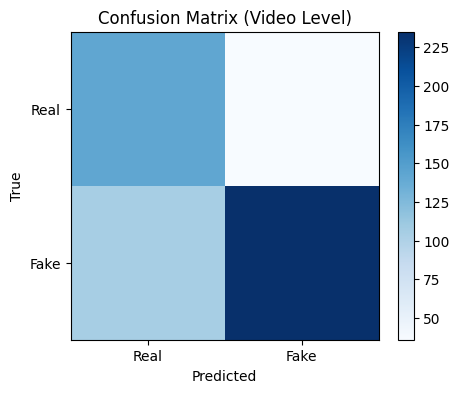

In [8]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, balanced_accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

def evaluate_test_set_per_video(model, dataset, k_clips=5):
    """
    Evaluate on test set by sampling K clips per video and averaging predictions.
    This provides a much more stable metric than single-clip accuracy.
    """
    model.eval()
    unique_videos = dataset.base_df["video_path"].unique()
    
    all_video_labels = []
    all_video_probs = []
    all_video_preds = []
    
    print(f"Evaluating on {len(unique_videos)} unique test videos (sampling {k_clips} clips each)...")
    
    for vid_path in tqdm(unique_videos, desc="TestVideos"):
        # Get label from metadata
        row = dataset.base_df[dataset.base_df["video_path"] == vid_path].iloc[0]
        label = int(row["label"])
        full_path = DATA_ROOT / vid_path
        
        # Read all frames once
        frames = read_video_frames(str(full_path), max_frames=CLIP_LEN * k_clips * 2, timeout=READ_VIDEO_TIMEOUT)
        
        if len(frames) < CLIP_LEN:
            # Skip or treat as error (here we skip or predict 0.5)
            continue
            
        # Sample K clips
        clip_batch = []
        for _ in range(k_clips):
            try:
                # Random start for variety
                cl = preprocess_clip(frames, clip_len=CLIP_LEN, frame_size=FRAME_SIZE, random_start=True, augment=False, detect_every=10)
                clip_batch.append(cl)
            except:
                pass
        
        if not clip_batch:
            continue
            
        # Batch inference
        clips_tensor = torch.stack(clip_batch).to(DEVICE) # [K, 3, T, H, W]
        
        with torch.no_grad():
            logits = model(clips_tensor) # [K, 1]
            logits = logits.squeeze(1)   # [K]
            probs = torch.sigmoid(logits) # [K]
            
        # Average probability across clips
        avg_prob = probs.mean().item()
        pred = 1 if avg_prob > 0.5 else 0
        
        all_video_labels.append(label)
        all_video_probs.append(avg_prob)
        all_video_preds.append(pred)
        
    # Metrics
    all_video_labels = np.array(all_video_labels)
    all_video_probs = np.array(all_video_probs)
    all_video_preds = np.array(all_video_preds)
    
    acc = (all_video_preds == all_video_labels).mean()
    bal_acc = balanced_accuracy_score(all_video_labels, all_video_preds)
    f1 = f1_score(all_video_labels, all_video_preds)
    try:
        auc = roc_auc_score(all_video_labels, all_video_probs)
    except:
        auc = 0.0
        
    print(f"\n=== Test Results (Per-Video Aggregation K={k_clips}) ===")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Balanced Acc:  {bal_acc:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    print(f"AUC:           {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_video_labels, all_video_preds, digits=4, target_names=["Real", "Fake"]))
    
    return all_video_labels, all_video_probs, all_video_preds

# Run evaluation
if 'test_dataset' in locals():
    vid_labels, vid_probs, vid_preds = evaluate_test_set_per_video(model, test_dataset, k_clips=5)
    
    # Optional: Confusion Matrix Plot
    cm = confusion_matrix(vid_labels, vid_preds)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Video Level)')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Real", "Fake"])
    plt.yticks(tick_marks, ["Real", "Fake"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## 1.B Test Evaluation of rPPG Baseline (AUC & Confusion Matrix)

After training the DeepFakesON-Phys-style rPPG baseline, we evaluate it on the **official Celeb-DF (v2) test set**.

We:
1. Runs the trained model on `test_loader`.
2. Computes:
   - Test loss (BCE)
   - Test accuracy
   - ROC AUC
3. Plots:
   - A 2x2 confusion matrix (Real vs Fake).
   - ROC curve

### Evaluate on test set (loss, acc, AUC)

Evaluating on 518 unique test videos (sampling 5 clips each)...


TestVideos: 100%|██████████| 518/518 [04:52<00:00,  1.77it/s]


=== Test Results (Per-Video Aggregation K=5) ===
Accuracy:      0.7162
Balanced Acc:  0.7343
F1 Score:      0.7578
AUC:           0.8169

Classification Report:
              precision    recall  f1-score   support

        Real     0.5618    0.7921    0.6573       178
        Fake     0.8614    0.6765    0.7578       340

    accuracy                         0.7162       518
   macro avg     0.7116    0.7343    0.7076       518
weighted avg     0.7584    0.7162    0.7233       518



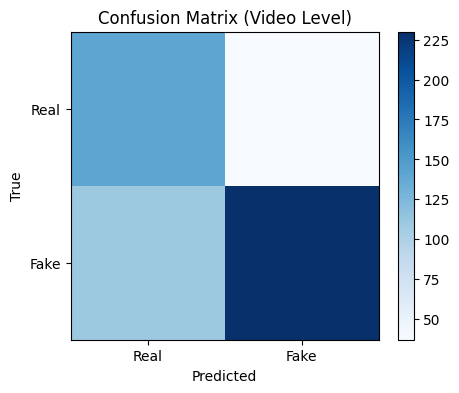

In [9]:
# Evaluation: Per-Video Metrics (AUC, F1, Balanced Acc)
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, balanced_accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

def evaluate_test_set_per_video(model, dataset, k_clips=5):
    """
    Evaluate on test set by sampling K clips per video and averaging predictions.
    This provides a much more stable metric than single-clip accuracy.
    """
    model.eval()
    unique_videos = dataset.base_df["video_path"].unique()
    
    all_video_labels = []
    all_video_probs = []
    all_video_preds = []
    
    print(f"Evaluating on {len(unique_videos)} unique test videos (sampling {k_clips} clips each)...")
    
    for vid_path in tqdm(unique_videos, desc="TestVideos"):
        # Get label from metadata
        row = dataset.base_df[dataset.base_df["video_path"] == vid_path].iloc[0]
        label = int(row["label"])
        full_path = DATA_ROOT / vid_path
        
        # Read all frames once
        frames = read_video_frames(str(full_path), max_frames=CLIP_LEN * k_clips * 2, timeout=READ_VIDEO_TIMEOUT)
        
        if len(frames) < CLIP_LEN:
            # Skip or treat as error (here we skip or predict 0.5)
            continue
            
        # Sample K clips
        clip_batch = []
        for _ in range(k_clips):
            try:
                # Random start for variety
                cl = preprocess_clip(frames, clip_len=CLIP_LEN, frame_size=FRAME_SIZE, random_start=True, augment=False, detect_every=10)
                clip_batch.append(cl)
            except:
                pass
        
        if not clip_batch:
            continue
            
        # Batch inference
        clips_tensor = torch.stack(clip_batch).to(DEVICE) # [K, 3, T, H, W]
        
        with torch.no_grad():
            logits = model(clips_tensor) # [K, 1]
            logits = logits.squeeze(1)   # [K]
            probs = torch.sigmoid(logits) # [K]
            
        # Average probability across clips
        avg_prob = probs.mean().item()
        pred = 1 if avg_prob > 0.5 else 0
        
        all_video_labels.append(label)
        all_video_probs.append(avg_prob)
        all_video_preds.append(pred)
        
    # Metrics
    all_video_labels = np.array(all_video_labels)
    all_video_probs = np.array(all_video_probs)
    all_video_preds = np.array(all_video_preds)
    
    acc = (all_video_preds == all_video_labels).mean()
    bal_acc = balanced_accuracy_score(all_video_labels, all_video_preds)
    f1 = f1_score(all_video_labels, all_video_preds)
    try:
        auc = roc_auc_score(all_video_labels, all_video_probs)
    except:
        auc = 0.0
        
    print(f"\n=== Test Results (Per-Video Aggregation K={k_clips}) ===")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Balanced Acc:  {bal_acc:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    print(f"AUC:           {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_video_labels, all_video_preds, digits=4, target_names=["Real", "Fake"]))
    
    return all_video_labels, all_video_probs, all_video_preds

# Run evaluation
if 'test_dataset' in locals():
    vid_labels, vid_probs, vid_preds = evaluate_test_set_per_video(model, test_dataset, k_clips=5)
    
    # Optional: Confusion Matrix Plot
    cm = confusion_matrix(vid_labels, vid_preds)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Video Level)')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Real", "Fake"])
    plt.yticks(tick_marks, ["Real", "Fake"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


### Visualization – confusion matrix & ROC curve

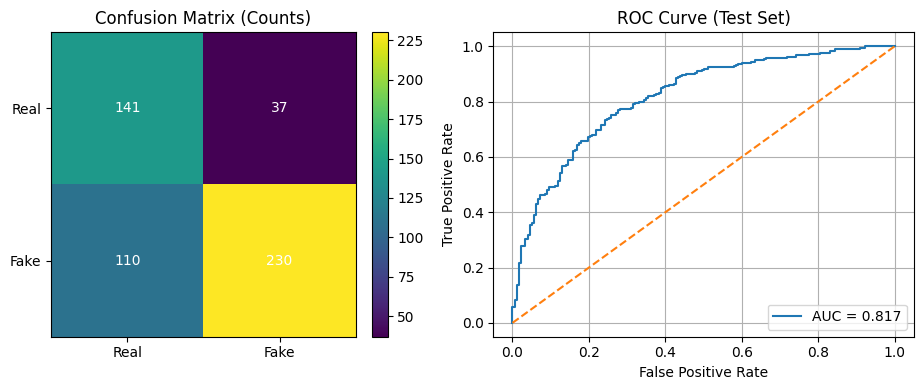

In [10]:
# Confusion matrix & ROC curve (using per-video results)
try:
    cm = confusion_matrix(vid_labels, vid_preds)
    cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Confusion matrix
    im0 = ax[0].imshow(cm, interpolation="nearest")
    ax[0].set_title("Confusion Matrix (Counts)")
    ax[0].set_xticks([0, 1])
    ax[0].set_yticks([0, 1])
    ax[0].set_xticklabels(["Real", "Fake"])
    ax[0].set_yticklabels(["Real", "Fake"])
    for i in range(2):
        for j in range(2):
            ax[0].text(j, i, cm[i, j], ha="center", va="center", color="w")
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    # ROC curve
    fpr, tpr, _ = roc_curve(vid_labels, vid_probs)
    auc_val = roc_auc_score(vid_labels, vid_probs)
    ax[1].plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    ax[1].plot([0, 1], [0, 1], linestyle="--")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve (Test Set)")
    ax[1].legend(loc="lower right")
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()
except NameError:
    print("Per-video evaluation not run yet. Run the evaluation cell first.")
